## Dataset Details :
- Flickr8k_Dataset.zip (1 Gigabyte) An archive of all photographs.
- Flickr8k_text.zip (2.2 Megabytes) An archive of all text descriptions for photographs.

- By unzipping above 2 files, it will generate below 2 files :
- 1. Flickr8k_Dataset: Contains 8092 photographs in JPEG format.
- 2. Flickr8k_text: Dataset folder which contains text files and captions of images.The dataset has a pre-defined training dataset (6,000 images), validation dataset (1,000 images), and test dataset (1,000 images).
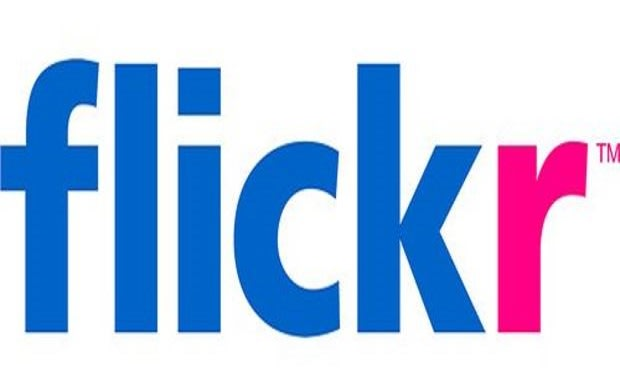

### Importing required libraries 

In [1]:
import re,string
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

import tensorflow as tf
from os import listdir                         # Search all the files within given directory
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16         # Lighter then AlexNet 
from keras.preprocessing.image import load_img     # Loads PIL image object
from keras.preprocessing.image import img_to_array # Convert Image to Array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
#from keras.models import Model    # DONT RUN THIS LINE, IT'S PREVIOUS VERSION , NOT SUPPORTED NOW

# https://www.captionbot.ai/

from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


#### Run below commands, it will extract and unzip the data in home directory 

In [2]:
#!wget 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
#!wget 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'

In [3]:
#!unzip 'Flickr8k_Dataset.zip'
#!unzip 'Flickr8k_text.zip'

In [2]:
# Load the Text File 

def open_mapping_descriptive_file(file):
    file = open(file, 'r')     
    text = file.read()
    file.close()
    return text

In [ ]:
# Only run this if this is first time
#image_description_mapping = open_mapping_descriptive_file('Flickr8k.token.txt')

In [3]:
# DATA CLEANING & MAPPING
# Each image is mapped with multiple description(5), which define whats the image is all about. Hence we will create 
# a mapping in such a way , so that instead of single id again and again mapped with all 5 desc , we will map it only once.

def image_id_to_desc_mapping(loaded_mapping_file):
    mapping_id_img = {}
    for line in loaded_mapping_file.split('\n'):  # Splitting every sentence by new line
        token = line.split()                      # Tokenization with space to separate image_id with its desciption 
        if len(line) < 2:                         # Skip empty lines
              continue
        image_id = token[0].split('.')[0]         # Extracting Image_id and separating it from .jpg extension
        descriptive_tokens = token[1:]
        clean_tokens = [word.lower() for word in descriptive_tokens if (word.isalpha()) and (len(word)>1) 
                        and word not in string.punctuation]
        descriptive_text = ' '.join(clean_tokens)  # Concatenating back the image desc which was tokeninzed
        if image_id not in mapping_id_img:         # So that we can create a dict item where each image_id is mapped to its desciption 
            mapping_id_img[image_id] = []          # We will create empty list here , so that descriptive text can be mapped here within list
        mapping_id_img[image_id].append(descriptive_text) # Append image descriptive text into the list 
    return mapping_id_img

In [ ]:
# Only run this if this is first time
#clean_mapping_img_desc = image_id_to_desc_mapping(image_description_mapping)

In [6]:
list(clean_mapping_img_desc.items())[:2]

[('1000268201_693b08cb0e',
  ['child in pink dress is climbing up set of stairs in an entry way',
   'girl going into wooden building',
   'little girl climbing into wooden playhouse',
   'little girl climbing the stairs to her playhouse',
   'little girl in pink dress going into wooden cabin']),
 ('1001773457_577c3a7d70',
  ['black dog and spotted dog are fighting',
   'black dog and dog playing with each other on the road',
   'black dog and white dog with brown spots are staring at each other in the street',
   'two dogs of different breeds looking at each other on the road',
   'two dogs on pavement moving toward each other'])]

In [68]:
# Let's save our dictionary for future purpose
def save_dictionary_clean_id_desc(dictionary, filename_name_to_be_saved):  
    lines = list()
    for key, desc_list in dictionary.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename_name_to_be_saved, 'w')
    file.write(data)
    file.close()

In [ ]:
# Only run this if this is first time
save_dictionary_clean_id_desc(clean_mapping_img_desc, 'clean_mapping_img_desc.txt')

In [70]:
!sed -n 1,5p 'clean_mapping_img_desc.txt'   # First 5 rows of our saved file

1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin


['hiker poses in green field with sheep',
 'man carrying backpack on his back walks in large field of grass',
 'man in field wearing backpack and there are sheep and mountains behind him',
 'man wearing hiking backpack is leaning on wooden pole',
 'man wearing black shirt is standing next to pole in grassy field']

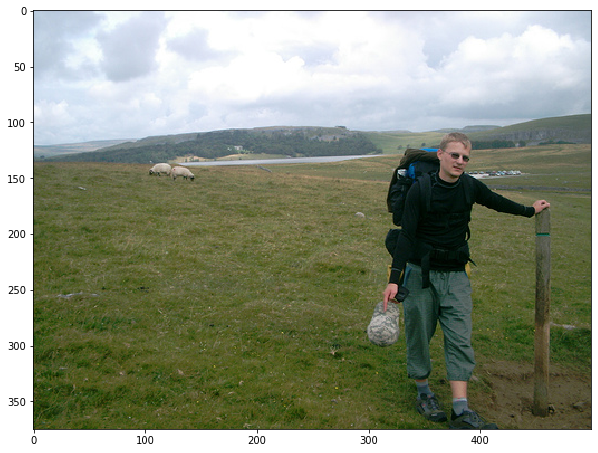

In [7]:
# Test some sample images and their respective captions
def sample_img_desc(dataset, index):
    image_name = os.listdir(dataset)[index]   
    img_location = dataset + '/' + image_name
    image = load_img(img_location)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(image)
    
    for image_id , desc in clean_mapping_img_desc.items():
        if image_id == image_name.split('.')[0]:
            return desc

sample_img_desc('Flicker8k_Dataset', 1)

In [64]:
# From all the captions available, let's build a set of unique tokens/vocabulary 

def vocab_dict_values(dictionary):
    new_l = []
    for key in dictionary.keys():
        for d in dictionary[key]:
            new_l.append(d.split())
    new_l = list(set(chain.from_iterable(new_l)))
    return new_l
vocabulary = vocab_dict_values(clean_mapping_img_desc)
print(f'Length of unique tokens/Vocabulary in our dataset is : {len(vocabulary)}')

8357

### Loading Train, Validation & Test dataset 

In [2]:
# NOTE - If you have already ran the above code , kindly run it from here only. 
# GENERIC FUNCTIONS 

def open_mapping_descriptive_file(file):
    file = open(file, 'r')     # file = open('Flickr8k.token.txt', 'r')
    text = file.read()
    file.close()
    return text

def image_id_to_desc_mapping(loaded_mapping_file):
    mapping_id_img = {}
    for line in loaded_mapping_file.split('\n'):          # Splitting every sentence by new line
        token = line.split()                  # Tokenization with space to separate image_id with its desciption 
        if len(line) < 2:                   # Skip empty lines
              continue
        image_id = token[0].split('.')[0]     # Extracting Image_id and separating it from .jpg extension
        descriptive_tokens = token[1:]
        clean_tokens = [word.lower() for word in descriptive_tokens if (word.isalpha()) and (len(word)>1) 
                        and word not in string.punctuation]
        descriptive_text = ' '.join(clean_tokens)  # Concatenating back the image desc which was tokeninzed
        if image_id not in mapping_id_img:   # So that we can create a dict item where each image_id is mapped to its desciption 
            mapping_id_img[image_id] = []    # We will create empty list here , so that descriptive text can be mapped here within list
        mapping_id_img[image_id].append(descriptive_text) # Append image descriptive text into the list 
    return mapping_id_img


In [3]:
train_dataset =      'Flickr_8k.trainImages.txt'  # 6000 Images
validation_dataset = 'Flickr_8k.devImages.txt'    # 1000 Images
test_dataset =       'Flickr_8k.testImages.txt'   # 1000 Images

In [4]:
!sed -n 1,3p 'Flickr_8k.trainImages.txt'   
print('*'*30)
!sed -n 1,3p 'Flickr_8k.devImages.txt'
print('*'*30)
!sed -n 1,3p 'Flickr_8k.testImages.txt'

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
******************************
2090545563_a4e66ec76b.jpg
3393035454_2d2370ffd4.jpg
3695064885_a6922f06b2.jpg
******************************
3385593926_d3e9c21170.jpg
2677656448_6b7e7702af.jpg
311146855_0b65fdb169.jpg


In [5]:
# Let's load the training data and fetch only it's image_id's .

train_description_mapping = open_mapping_descriptive_file(train_dataset)
print(f'Total images present in Train dataset is {len(train_description_mapping)}')
train_clean_mapping_img_desc = image_id_to_desc_mapping(train_description_mapping)
train_images_ids = list(train_clean_mapping_img_desc.keys())
print(f'Total clean images present in Train dataset is {len(train_images_ids)}')

Total images present in Train dataset is 154678
Total clean images present in Train dataset is 6000


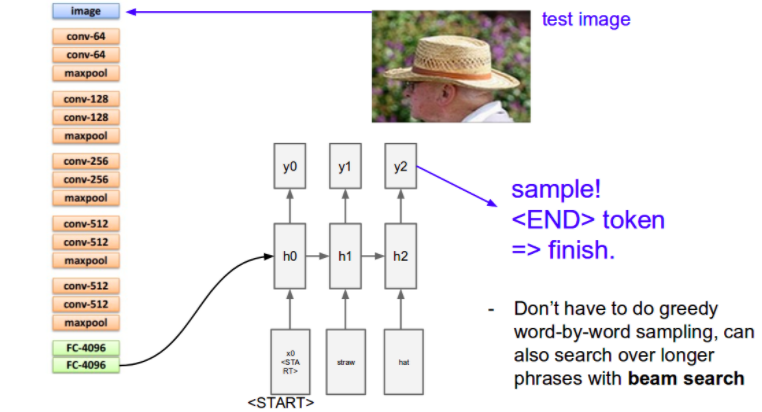
- We will initialise ‘first word’ with ‘startseq‘ to kick-off the generation process.
- And a ‘last word‘ with ‘endseq‘ to tell the model that this is the end of the caption.

In [6]:
# From our clean mapping file ,which we stored earlier. Let's map the training image id's , to the captions saved in this file. 
# We will use these id's to filter photos and descriptions(captions) for each image.

saved_cleaned_file = open_mapping_descriptive_file('clean_mapping_img_desc.txt')   

# Code here is changed then earlier code, because we are doing mapping with our already saved file

def train_image_id_to_desc_mapping(train_images_ids, loaded_mapping_file):   
    image_description = {}
    for id_desc_mapping in loaded_mapping_file.split('\n'):
        image_id = id_desc_mapping.split()[0]
        image_desc = id_desc_mapping.split()[1:] 
        descriptive_text = 'startseq ' + ' '.join(image_desc) + ' endseq'
        #descriptive_text = ' '.join(image_desc)
        if image_id in train_images_ids :
            if image_id not in image_description:
                image_description[image_id] = []
            image_description[image_id].append(descriptive_text)
    return image_description

train_id_desciptions = train_image_id_to_desc_mapping(train_images_ids, saved_cleaned_file)

print(f'Now our Training id\'s of length {len(train_id_desciptions)} are properly tagged with stored clean dictionary mapping file')

Now our Training id's of length 6000 are properly tagged with stored clean dictionary mapping file


In [7]:
list(train_id_desciptions.items())[1]

('1001773457_577c3a7d70',
 ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'])

## VGG 16 Model   ( Encode images into feature vectors )
- We will remove the last layer, as we are not doing any classification on images here.
- However, we will use our own layers beyond that via Transfer Learning.
- The final output of this archtecture has image features of a 1-dimensional 4,096 element vector.

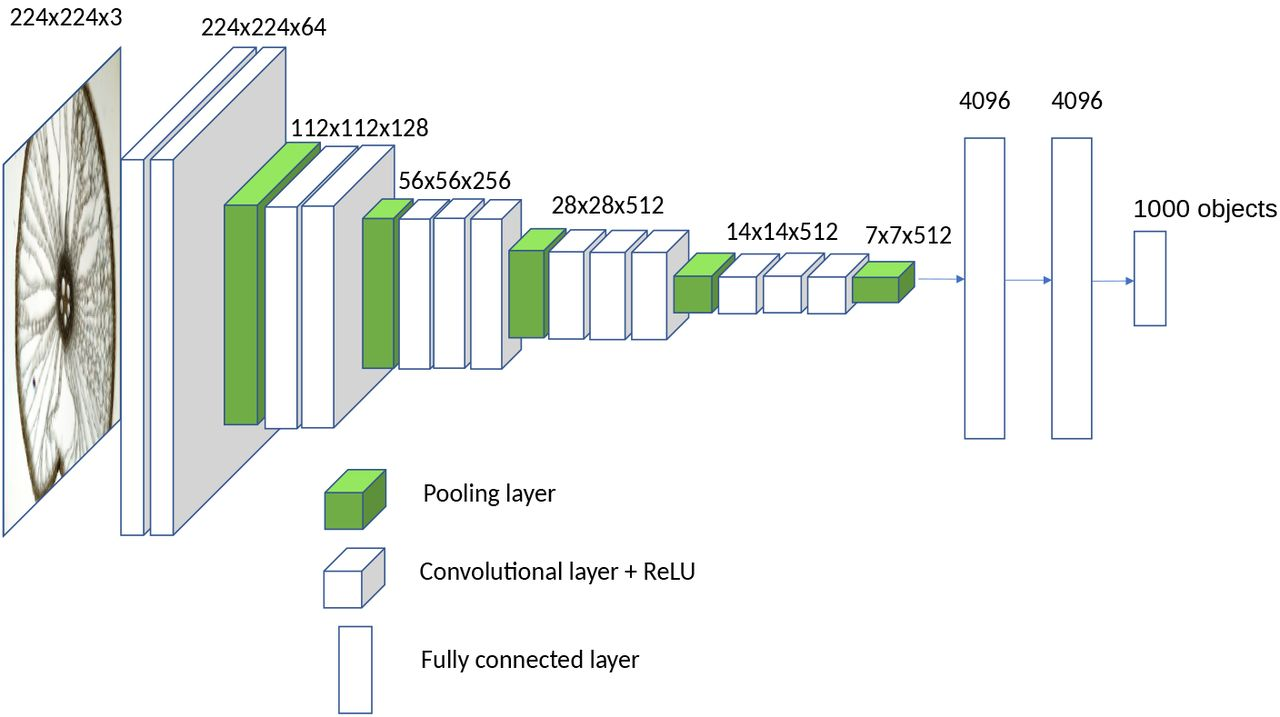

In [ ]:
# NOTE - Do not run this code, if you have already trained your model on images and pickled it 'VGG16_Image_Captioning_Weight.pkl'

def model_mapping(dataset_directory):
    model = VGG16()
    model.layers.pop()     # Model Re-structuring will remove the last layer from VGG-16 , as we are not doing Classification problem
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    model.summary()
    image_feature_mapping = dict()
    image_processed = 0
    for filename in listdir(dataset_directory):         # filename is 2715289538_d77c8d0a85.jpg
        filepath = dataset_directory + '/' + filename   # Flicker8k_Dataset/2715289538_d77c8d0a85.jpg
        image = load_img(filepath, target_size=(224, 224))    
        image = img_to_array(image)                     # Image to Array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # Reshaping data from (224, 224, 3) to (1, 224, 224, 3)
        image = preprocess_input(image)                 # Preparing dataset as per VGG-16 Requirement
        feature = model.predict(image, verbose=0)
        image_id = filename.split('.')[0]               # Extracting Imags id's
        image_feature_mapping[image_id] = feature       # Mapping Features to respective Image_id's
        #image_processed += 1
    #print(f'Total {len(image_processed)} images processed')
    return image_feature_mapping

dataset_directory = 'Flicker8k_Dataset'    # (1, 4096)
image_feature_mapping = model_mapping(dataset_directory)
print('Done')

print(f'We have extracted features from the dataset')
dump(image_feature_mapping, open('VGG16_Image_Captioning_Weight.pkl', 'wb'))
print('Model weights are successfully dumped')  # Architecture, Weights, Training configuration i.e Loss & Optimizer

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
!sed -n 1,10p 'VGG16_Image_Captioning_Weight.pkl'   # First 5 rows of our saved pickled file

�}q (X   2715289538_d77c8d0a85qcnumpy.core.multiarray
_reconstruct
qcnumpy
ndarray
qK �qCbq�qRq(KKM �qcnumpy
dtype
q	X   f4q
NNNJ����J����K tqb�B @                          ���>\c�>
@        r�W?    "�T@    �?    �-S@        �O�>                ��?                -�>        �?                    2�	@���?    E�@�=            E�>    vDu??�@                                l�O@    q=@                    ���?        �M�>@    ���?                                �4X?    �@        *��>%�;@            ��+=        S�?+��>                    �?�[@        N�l>    [I?f��>                    ��9@.�s@                    M��?        h�@        �@            ��>            �{@���?    ��7@    �@        ��I@�&>%P�?    c�@��=    �O?        �hV?0�:?                ��[?�i?        0�@                            ��9@(?.@�@    �R@Dxx@            �.?4(?�n?                �a>0z0>    �@��@            �?            ,D7?^�-?                        x�p=     

In [8]:
print('Let\'s load the Model back to the disk :')
pickled_features = load(open('VGG16_Image_Captioning_Weight.pkl', 'rb'))   # Keras load_model function
print(f'For all complete data, we have successfully extracted features for {len(pickled_features)} images')

Let's load the Model back to the disk :
For all complete data, we have successfully extracted features for 8091 images


## Attribute/Feature Detector Phase
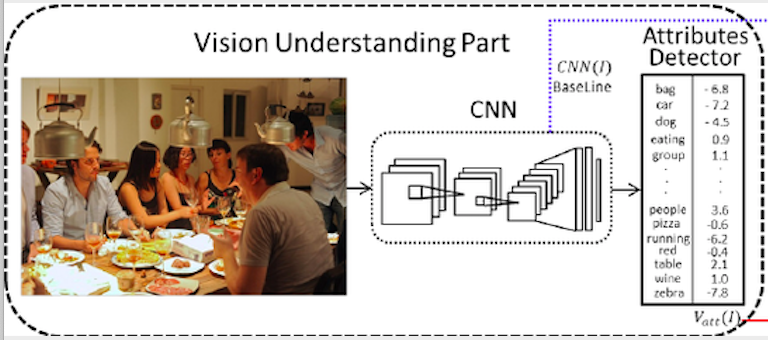

In [9]:
# We will load our saved Pickled Model , where we have extracted features for each image using VGG16
# Now, in out training set, we have image id's, we will map these image id's with respective feature vectors extracted using VGG16
# Here, for every image and it's dominand pixel, we have its feautre vector

def mapping_train_data(pickled_model, train_images_ids):
    pickled_features = load(open(pickled_model, 'rb'))
    id_features = {image_ids: pickled_features[image_ids] for image_ids in train_images_ids}
    return id_features

train_data = mapping_train_data('VGG16_Image_Captioning_Weight.pkl', train_images_ids)   # Mapping training image_id's with VGG16 Trained features

In [10]:
list(train_data.items())[1]

('2903617548_d3e38d7f88',
 array([[0.       , 0.       , 1.5557895, ..., 0.317212 , 0.       ,
         0.       ]], dtype=float32))

In [11]:
list(train_id_desciptions.items())[0]

('1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

In [10]:
# Tokenization, Max_length_caption, train_vocabulary

def train_values_tokenizer(dictionary):
    new_l = []
    for key in dictionary.keys():
        for d in dictionary[key]:
            new_l.append(d)
    max_length_sentence = max(len(each_line.split()) for each_line in new_l)  # As different captions have different lengths, we only want to see which caption has max length. Used later for padding
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(new_l)   # Tokenize all the values/desc present in train_id_desciptions dict
    return tokenizer , max_length_sentence

train_value_tokenizer, max_length_sentence = train_values_tokenizer(train_id_desciptions)
vocab_train = len(train_value_tokenizer.word_index)+1   # We add 1 here, because in Python indexing starts from 0
print(f'Total no. of tokens present in our Train dataset is {vocab_train}')
print(f'Max length reviews has maximum length of {max_length_sentence}')

Total no. of tokens present in our Train dataset is 7266
Max length reviews has maximum length of 33


In [13]:
print(f'Let\'s save this Tokenizer, as it will required later for Testing :')
dump(train_value_tokenizer, open('train_value_tokenizer.pkl', 'wb'))

In [ ]:
'''
def sequencing_model_input(train_id_desciptions,train_data,train_value_tokenizer,max_length_sentence, vocab_train):
    for image_id, image_description in train_id_desciptions.items():
        train_vectors = train_data[image_id][0]   # np.squeeze(photo), [0] is used to remove 1 extra dimension. Here, we are taking extracted featues from CNN Model and mapping it with our train data image_id's
        #print(photo.shape)           # (4096,)
        #break
        
        CNN_image_feature = []  # VGG16 Trained feature
        word_index_vector = []  # Later treated as word embedding
        Output = []             # OHE, generated from CNN_image_feature + word_index_vector
        
        for desc in image_description:
        #break
            sequence = train_value_tokenizer.texts_to_sequences([desc])[0]   # np.squeeze(desc), [0] is used to remove 1 extra dimension. [[]] to []
            #print(sequence)                     # [40, 1, 85, 167, 4, 115, 53, 389, 9, 390, 1, 25, 4378, 637]
            #print(desc)                         # child in pink dress is climbing up set of stairs in an entry way
        #break
        
            for i in range(1, len(sequence)):   
                in_seq  = sequence[:i] # Each word will predict the next word for the caption, and with next word it gets concatenated to predict their next word
# [[40], [40, 1], [40, 1, 85], [40, 1, 85, 167] .....]]
                out_seq = sequence[i]  # Output word predicted from in_seq
# [1, 85, 167, 4, 115, 53, 389, 9, 390, 1, 25, 4378, 637] --- (40) predicted 1, (40,1) predicted 85, (40,1,85) predicted 167 and so on 
                in_seq_padded = pad_sequences([in_seq], maxlen = max_length_sentence)[0]

#Padding for each token, so that they can become equal size
#for first token = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40]
#for last token = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,1,85,67,4,115,53,389,9,390,1,25,4378]

                out_seq_ohe = to_categorical([out_seq], num_classes = vocab_train)[0]

 
#Image Captioning - Word_indexed in_seq with CNN image feature vector predicts out_seq
#out_seq is OHE representation of length of vocab i.e 7266
    
                CNN_image_feature.append(train_vectors)
                word_index_vector.append(in_seq_padded)
                Output.append(out_seq_ohe)
            
            yield [[np.array(CNN_image_feature), np.array(word_index_vector)], np.array(Output)]
 '''

- Captions are generated one word at a time. 
- Sequence of previously generated words will be provided as input to the next. 
- We will initialise ‘first word’ with ‘startseq‘ to kick-off the generation process.
- And a ‘last word‘ with ‘endseq‘ to tell the model that this is the end of the caption.

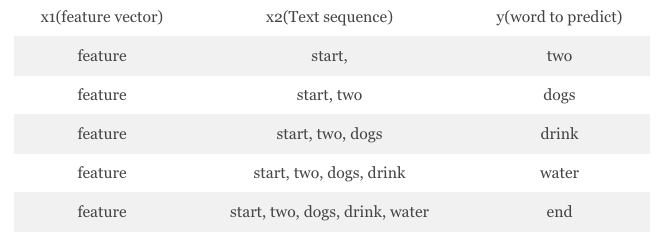

In [13]:
def sequence_generation(train_value_tokenizer, max_length_sentence, image_description, train_vectors, vocab_train):
    CNN_image_feature = []  # VGG16 Trained feature
    word_index_vector = []  # Later treated as word embedding
    Output = []             # OHE, generated from CNN_image_feature + word_index_vector

    for desc in image_description:
        sequence = train_value_tokenizer.texts_to_sequences([desc])[0]   # np.squeeze(desc), [0] is used to remove 1 extra dimension. [[]] to []
        #print(sequence)                     # [40, 1, 85, 167, 4, 115, 53, 389, 9, 390, 1, 25, 4378, 637]
        #print(desc)                         # child in pink dress is climbing up set of stairs in an entry way

        for i in range(1, len(sequence)):
            in_seq = sequence[:i]            # Each word will predict the next word for the caption, and with next word it gets concatenated to predict their next word
                                             # [[40], [40, 1], [40, 1, 85], [40, 1, 85, 167] .....]]
                
            out_seq = sequence[i]            # Output word predicted from in_seq
                                             # [1, 85, 167, 4, 115, 53, 389, 9, 390, 1, 25, 4378, 637] --- (40) predicted 1, (40,1) predicted 85, (40,1,85) predicted 167 and so on 

            in_seq_padded = pad_sequences([in_seq], maxlen = max_length_sentence)[0]
#Padding for each token, so that they can become equal size
#for first token = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40]
#for last token = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,1,85,67,4,115,53,389,9,390,1,25,4378]

            out_seq_ohe = to_categorical([out_seq], num_classes = vocab_train)[0]
#Image Captioning - Word_indexed in_seq with CNN image feature vector predicts out_seq
#out_seq is OHE representation of length of vocab i.e 7266  ( 2 Extra for Startseq & Endseq)

            CNN_image_feature.append(train_vectors)
            word_index_vector.append(in_seq_padded)
            Output.append(out_seq_ohe)
            
    return array(CNN_image_feature), array(word_index_vector), array(Output)
          
def data_generator_for_rnn(train_id_desciptions, train_data, train_value_tokenizer, max_length_sentence, vocab_train):
    while 1:    # So that It can keep running
        for image_id, image_description in train_id_desciptions.items():
            train_vectors = train_data[image_id][0]
            
            CNN_image_feature, word_index_vector, Output = sequence_generation(train_value_tokenizer, max_length_sentence, image_description, train_vectors, vocab_train)
            yield [[CNN_image_feature, word_index_vector], Output]

In [14]:
inputs, outputs = next(data_generator_for_rnn(train_id_desciptions, train_data, train_value_tokenizer, max_length_sentence, vocab_train))
print(f'Last layer from VGG16 left for Transfer learning {inputs[0].shape}')
print(f'To start our training, input shape for the model will be {inputs[0][1].shape}')
print(f'Final output of the model to generate captions would be {outputs.shape} \n')

print('In easy language, we can consider this is following :/n ')
print(f'CNN output x_train_IMAGE is                  : {inputs[0].shape}')
print(f'LSTM outputx_train_TEXT is                   : {inputs[1].shape}')
print(f'Predicted OHE word vector is y_train_TEXT is : {outputs.shape}')

Last layer from VGG16 left for Transfer learning (47, 4096)
To start our training, input shape for the model will be (4096,)
Final output of the model to generate captions would be (47, 7266) 

In easy language, we can consider this is following :/n 
CNN output x_train_IMAGE is                  : (47, 4096)
LSTM outputx_train_TEXT is                   : (47, 33)
Predicted OHE word vector is y_train_TEXT is : (47, 7266)


# Model Architecture :
- 1. Feature Extractor from Images Phase - We have used 16-layer VGG model without the output layer, which is already pre-trained on the ImageNet dataset.This output layer has extracted features predicted by this model which becomes input to our RNN LTSM Model.Also, this output layer which is our dense feature vector/embedding layer is fed as initial state into an LSTM.
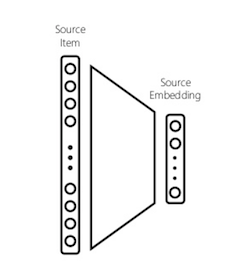
- 2. Sequence Processor Phase - Actually, this is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer. LSTM helps in solving problems with temporal dependences. It succeeds in capturing information from previous states to better inform the current prediction through its memory cell state.
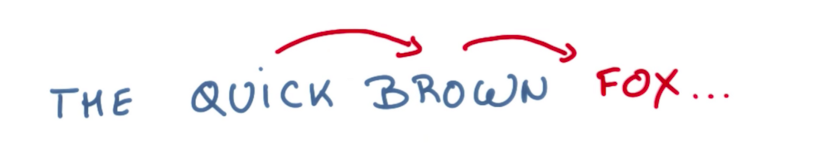
-     At each time-step, the LSTM considers the previous cell state and outputs a prediction for the most probable next value in the sequence. This process is repeated until the end token is sampled, signaling the end of the caption.
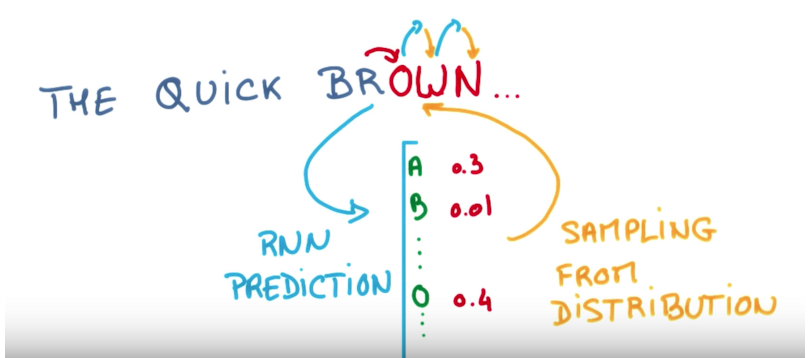
- Sampling and choosing the most probable next value is a greedy approach to generating a caption.But with too much words, it becomes computationally inefficient, hence we come up with advance techniques like Breadth First Search/Beam Search

- 3. Decoder Phase - Both the 1st and 2nd phase together output a fixed-length vector which are merged together and processed by a Dense layer to make a final prediction.
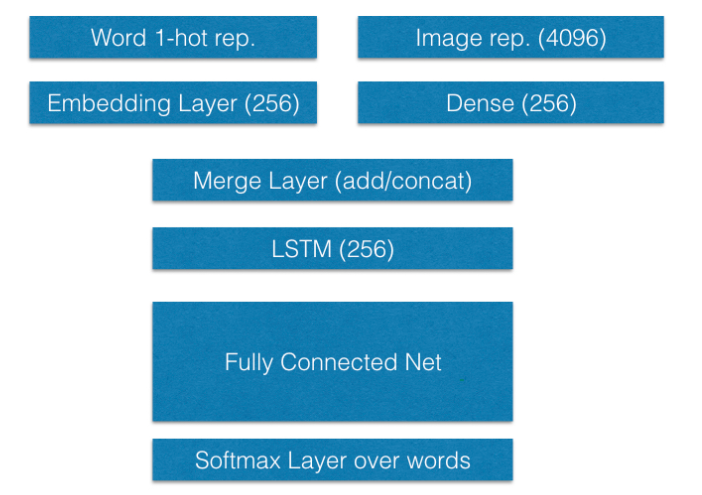

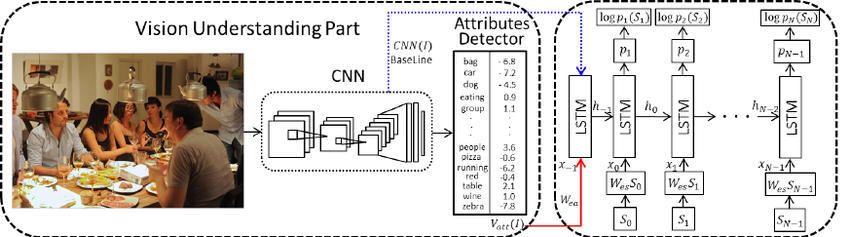

In [2]:
import keras
import tensorflow as tf
import sys, time
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import ModelCheckpoint
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); 
#del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
keras version 2.2.2
tensorflow version 1.14.0


In [3]:
def model_arch(vocab_train, max_length_sentence):
    Input_image = Input(shape=(inputs[0][1].shape))      # CNN Feature Extractor Phase with input size 4096
    Layer1 = Dropout(0.5)(Input_image)                   # 50 % to avoid Overfitting
    Layer2 = Dense(256, activation='relu')(Layer1)       # 4096 Image Feature Vector is reduced to 256 Vector
    
    # Input Sequence of max_length_sentence is fed here to the Embedding layer
    Input_text  = Input(shape=(max_length_sentence,))                       # Sequence Model Encoder Phase 
    text_layer1 = Embedding(vocab_train, 256, mask_zero=True)(Input_text)   # Specify of Embedding feature vector here. I have taken 256
    text_layer2 = Dropout(0.5)(text_layer1)                                 # mask_zero=True means Ignore Padded Value
    text_layer3 = LSTM(256)(text_layer2)
   
    # Merging Vectors of Both CNN + LSTM with addition operation
    Decoder1 = add([Layer2, text_layer3])                             # Sequence Model Decoder Phase
    Decoder2 = Dense(256, activation='relu')(Decoder1)
    outputs  = Dense(vocab_train, activation='softmax')(Decoder2)
    
    model = Model(inputs=[Input_image, Input_text], outputs=outputs)  # Meger Phase
    #adam = keras.optimizers.Adam(lr=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer='adam')  #model.optimizer.lr = 0.0001

    model.summary()
    #plot_model(model, to_file='model_arch.png', show_shapes=True)
    return model

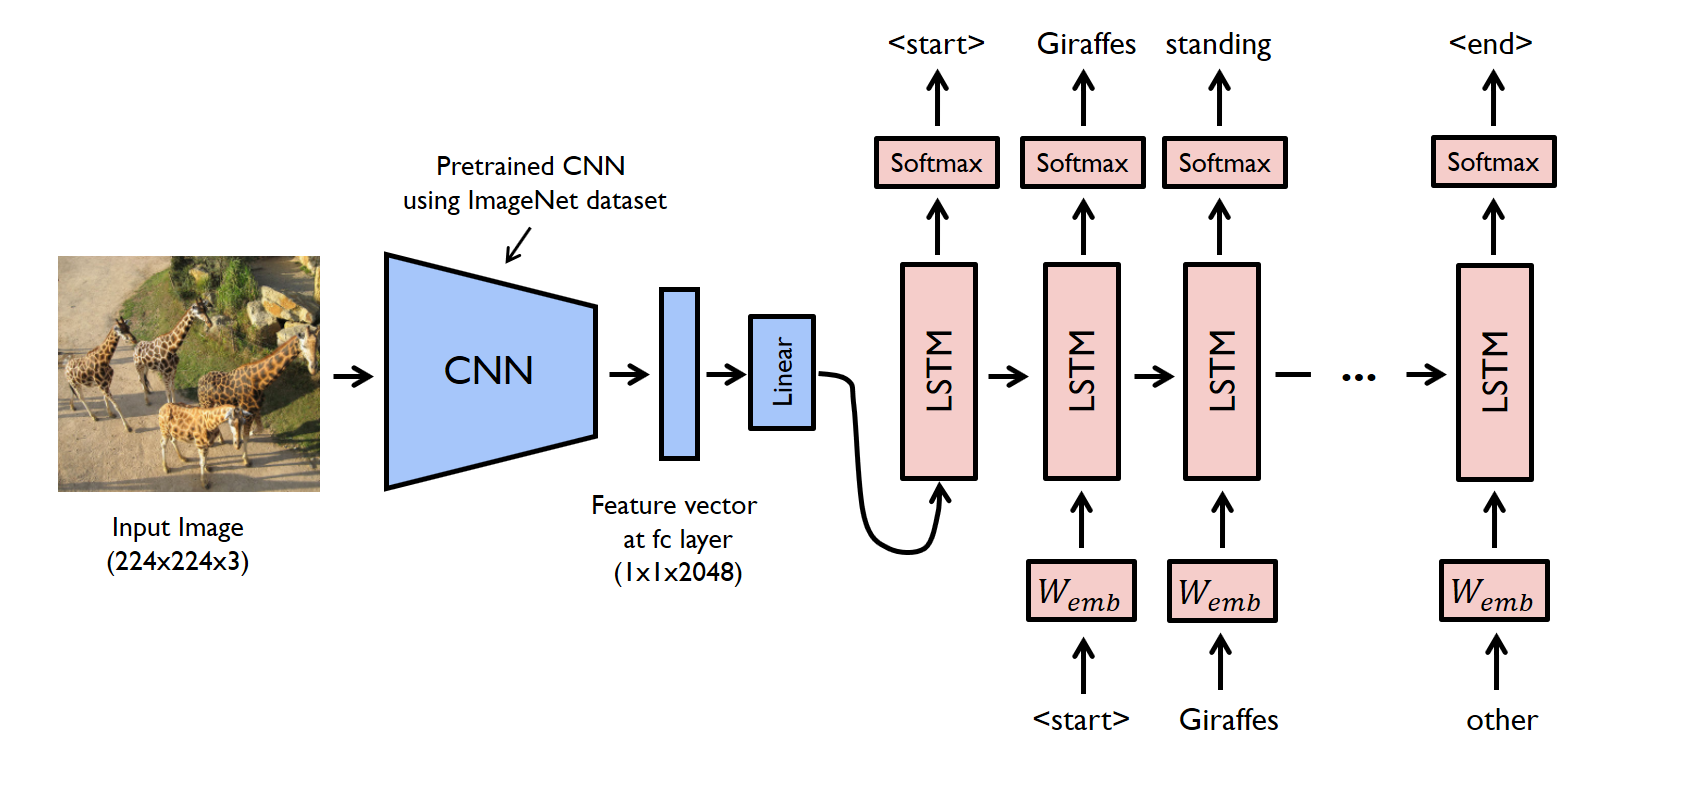

### Progressive Training of the Model 
- Keras provide fit_generator function to achieve progressive training
- System with memory < 32gb are recommended to do progressive training, to avois system crash
- We have already developed our own standalone Generator function 'data_generator_for_rnn', which will be passed to fit_generator for fitting the model every epoch. It will create 1 yeild/batch of dataset.

In [ ]:
epochs = 10
batch_size = 1
steps = len(train_id_desciptions)//batch_size   # As we have 6k images in our training data, we can divide it with any batch_size

model_training = model_arch(vocab_train, max_length_sentence)  # Initiate our Model Function

start = time.time()

hist_performance = []
for i in range(epochs):
    generator = data_generator_for_rnn(train_id_desciptions, train_data, train_value_tokenizer, max_length_sentence, vocab_train)        
    
    hist = model_training.fit_generator(generator, epochs = epochs, steps_per_epoch = steps)

    #model_training.fit([inputs[0], inputs[1]], outputs, epochs=epochs, verbose=1, callbacks=[checkpoint])
    hist_performance.append(hist)

    model_training.save('Image_captioning_weights' + str(i) + '.h5')   # .h5 will be generated as per size of no. of Epochs
   
end = time.time()
print("Total time taken is {:3.2f} minutes".format((end - start )/60))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 33, 256)      1860096     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 4096)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dropout_6 

## Model Testing on Sample Image

In [2]:
!ls -lrt |tail

-rw-r--r-- 1 eduaman14892859 eduaman14892859     840856 May  8 21:04 Classify_Clothes_Tensorflow-model_arch2.ipynb
drwxrwxr-x 3 eduaman14892859 eduaman14892859       4096 May  9 08:37 __MACOSX
-rw-r--r-- 1 eduaman14892859 eduaman14892859    2932700 May  9 14:11 clean_mapping_img_desc.txt
-rw-r--r-- 1 eduaman14892859 eduaman14892859  133296870 May 10 07:55 VGG16_Image_Captioning_Weight.pkl
-rw-r--r-- 1 eduaman14892859 eduaman14892859     990266 May 11 08:08 captioning_sample_imag.jpg
-rw-r--r-- 1 eduaman14892859 eduaman14892859       2858 May 11 17:51 Untitled.ipynb
-rw-r--r-- 1 eduaman14892859 eduaman14892859   64456112 May 11 20:06 Image_captioning_weights0.h5
-rw-r--r-- 1 eduaman14892859 eduaman14892859     336274 May 12 07:10 train_value_tokenizer.pkl
drwxr-xr-x 3 eduaman14892859 eduaman14892859       4096 May 12 13:06 sample_images
-rw-r--r-- 1 eduaman14892859 eduaman14892859    3636837 May 12 13:24 Image_Captioning_CNN_RNN.ipynb


In [3]:
train_value_tokenizer = load(open('train_value_tokenizer.pkl', 'rb'))   # Keras load_model function
max_length_sentence = 33

In [4]:
# Let's load our vocabulary tokenized file again and perform its word_index mapping
# This word be useful in calculating BLEU Score where we compare predicted tokens with Actual Tokens

#vocab_index_mapping = dict([(index,word) for word, index in train_value_tokenizer.word_index.items()])
vocab_index_mapping ={}
for word, index in train_value_tokenizer.word_index.items():
      if index not in vocab_index_mapping:
            vocab_index_mapping[index]=word
            
list(vocab_index_mapping.items())[:5]

[(1, 'startseq'), (2, 'endseq'), (3, 'in'), (4, 'the'), (5, 'on')]

In [5]:
print(f'Our current working directory is : {os.getcwd()}')
model_weights = 'Image_captioning_weights0.h5'
#model_weights = '/home/eduaman14892859/nitin_model_18.h5'
#model_weights = '/home/eduaman14892859/VGG16_final_git.h5'


print('Let\'s load the Keras Final Model (CNN+RNN) back to the disk :')
keras_model_weights = load_model(model_weights)
print(f'Final Model Successfully loaded')

W0512 13:26:51.935477 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:515: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0512 13:26:51.963466 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:72: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0512 13:26:51.966742 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4048: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0512 13:26:51.985431 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

Our current working directory is : /home/eduaman14892859
Let's load the Keras Final Model (CNN+RNN) back to the disk :


W0512 13:26:52.348757 140605235664704 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2925: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0512 13:26:52.500062 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:172: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0512 13:26:52.679092 140605235664704 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.6/site-packages/keras/optimizers.py:782: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Final Model Successfully loaded


In [6]:
!sed -n 1,5p 'Image_captioning_weights0.h5'  



                    �����������    ��������        `              �       �                                     TREE   ����������������         (                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             HEAP    X       0       �              model_weights   optimizer_weights              (                                     �       �       H        keras_version                                          @        backend                          
   model_config                     

In [7]:
# Training our Single Test Image 
def feature_extractor_evaluater(test_image):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(test_image, target_size=(224, 224))
    plt.imshow(image)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image_feature = model.predict(image, verbose=0)
    return image_feature

In [8]:
# Building Caption for our Single Test Image 

def build_caption_test_image(max_length_sentence,train_value_tokenizer,keras_model_weight, test_image_vgg_features):
    caption = 'startseq'
    for i in range(max_length_sentence):  # Generate 1 word per iteration and generate it until it reach endseq or max_length
        sequence = train_value_tokenizer.texts_to_sequences([caption])[0]        # Assign and initiate the caption, it will be appended as it find a ne predicted word
        in_seq_padded = pad_sequences([sequence], maxlen = max_length_sentence)     # Make it of same length, dont squeeze here, it has to be (1, 33) not only (33,) 
        predicted_prob = keras_model_weight.predict([test_image_vgg_features,in_seq_padded], verbose=0)
        max_index = np.argmax(predicted_prob)
        predicted_word = vocab_index_mapping[max_index]  # We are mapping this index with max probablity to find the token from our token-index mapping dict
        caption += " " + predicted_word
        if predicted_word == 'endseq':
            break
    final_caption = caption.split()  # We are splitting here , so that we can remove startseq & endseq token at start and end
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption) # After it's removed, time to join back the substrings into a single string
    return final_caption

W0512 13:26:55.386095 140605235664704 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


'dog is running through the snow'

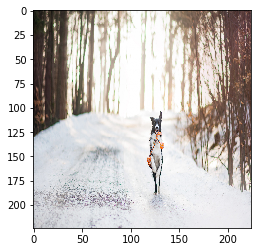

In [9]:
test_image = 'captioning_sample_imag.jpg'

single_image_feature = feature_extractor_evaluater(test_image)
build_caption_test_image(max_length_sentence,train_value_tokenizer,keras_model_weights,single_image_feature)

man in red shirt is sitting on rock


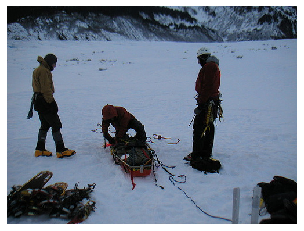

man in black shirt and white pants is standing in front of an old building


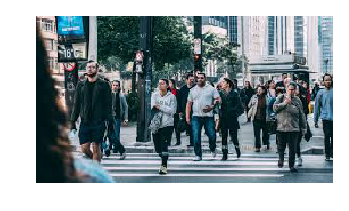

dog is running through the water


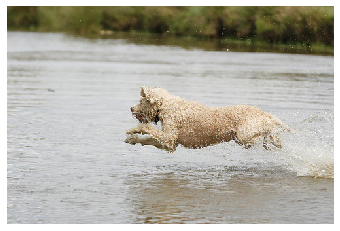

man in black shirt and white pants is standing next to bus


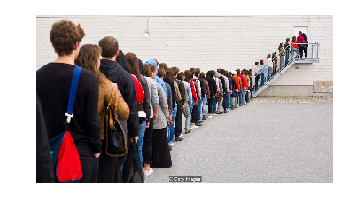

boy in red swimsuit is playing in the water


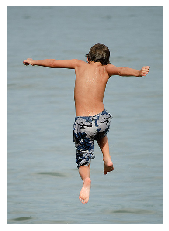

dog is running through the grass


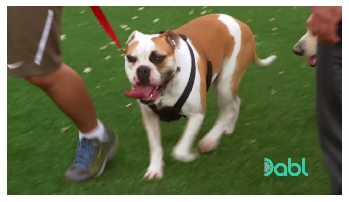

In [10]:
sample_directory = '/home/eduaman14892859/sample_images'
for each_file in listdir(sample_directory):
    if each_file != '.ipynb_checkpoints':
        filepath = sample_directory + '/' + each_file
        single_image_feature = feature_extractor_evaluater(filepath)
        caption = build_caption_test_image(max_length_sentence,train_value_tokenizer,keras_model_weights,single_image_feature)
        print(caption)
        image = load_img(filepath)
        imgplot = plt.imshow(image)
        plt.axis('off')
        plt.show()

## Model Evaluation Accuracy Check

In [73]:
def open_mapping_descriptive_file(file):
    file = open(file, 'r')     # file = open('Flickr8k.token.txt', 'r')
    text = file.read()
    file.close()
    return text

def image_id_to_desc_mapping(loaded_mapping_file):
    mapping_id_img = {}
    for line in loaded_mapping_file.split('\n'):          # Splitting every sentence by new line
        token = line.split()                  # Tokenization with space to separate image_id with its desciption 
        if len(line) < 2:                   # Skip empty lines
              continue
        image_id = token[0].split('.')[0]     # Extracting Image_id and separating it from .jpg extension
        descriptive_tokens = token[1:]
        clean_tokens = [word.lower() for word in descriptive_tokens if (word.isalpha()) and (len(word)>1) 
                        and word not in string.punctuation]
        descriptive_text = ' '.join(clean_tokens)  # Concatenating back the image desc which was tokeninzed
        if image_id not in mapping_id_img:   # So that we can create a dict item where each image_id is mapped to its desciption 
            mapping_id_img[image_id] = []    # We will create empty list here , so that descriptive text can be mapped here within list
        mapping_id_img[image_id].append(descriptive_text) # Append image descriptive text into the list 
    return mapping_id_img


def train_image_id_to_desc_mapping(train_images_ids, loaded_mapping_file):   
    image_description = {}
    for id_desc_mapping in loaded_mapping_file.split('\n'):
        image_id = id_desc_mapping.split()[0]
        image_desc = id_desc_mapping.split()[1:] 
        descriptive_text = 'startseq ' + ' '.join(image_desc) + ' endseq'
        #descriptive_text = ' '.join(image_desc)
        if image_id in train_images_ids :
            if image_id not in image_description:
                image_description[image_id] = []
            image_description[image_id].append(descriptive_text)
    return image_description


def mapping_train_data(pickled_model, train_images_ids):
    pickled_features = load(open(pickled_model, 'rb'))
    id_features = {image_ids: pickled_features[image_ids] for image_ids in train_images_ids}
    return id_features

In [55]:
test_dataset = 'Flickr_8k.testImages.txt'   # 1000 Images
print(f'Successfully loaded Test Dataset : {test_dataset} \n')

test_description_mapping = open_mapping_descriptive_file(test_dataset)
print(f'Total images present in Test dataset is : {len(test_description_mapping)} \n')

test_clean_mapping_img_desc = image_id_to_desc_mapping(test_description_mapping)
test_images_ids = list(set(test_clean_mapping_img_desc.keys()))
print(f'Total clean image id\'s present in Test dataset is : {len(test_images_ids)} \n')

# To map our Test data id\'s with captions/descriptions from clean main dataset, we need to first load that clean file, then run our below function' 
saved_cleaned_file = open_mapping_descriptive_file('clean_mapping_img_desc.txt') 
print(f'Successfully loaded Clean Id-Description file trained on all images \n')

test_id_desciptions = train_image_id_to_desc_mapping(test_images_ids, saved_cleaned_file)
print(f'Mapping done for our {len(test_id_desciptions)} Test image id\'s with Description/Captions of the Main Trained File \n')

print('Let\'s load our CNN Keras VGG16 Model back to the disk :')
pickled_features = load(open('VGG16_Image_Captioning_Weight.pkl', 'rb'))   # CNN Keras load_model function
print(f'Model Successfully loaded and this model was earlier trained on {len(pickled_features)} images \n')

print('While running our Evaluator Function, Pass this variable instead of single_image_feature made earlier')
test_data = mapping_train_data('VGG16_Image_Captioning_Weight.pkl', test_images_ids)
print(f'Successfully mapped these above model extracted features of VGG16 with our loaded {len(test_images_ids)} test images \n')

print('ALL DONE, PLEASE RUN THE EVALUATOR')

Successfully loaded Test Dataset : Flickr_8k.testImages.txt 

Total images present in Test dataset is : 25775 

Total clean image id's present in Test dataset is : 1000 

Successfully loaded Clean Id-Description file trained on all images 

Mapping done for our 1000 Test image id's with Description/Captions of the Main Trained File 

Let's load our CNN Keras VGG16 Model back to the disk :
Model Successfully loaded and this model was earlier trained on 8091 images 

While running our Evaluator Function, Pass this variable instead of single_image_feature made earlier
Successfully mapped these above model extracted features of VGG16 with our loaded 1000 test images 

ALL DONE, PLEASE RUN THE EVALUATOR


## Bleu Score - Bilingual Evaluation Understudy Score
- Quick, inexpensive, language independent, highly interpretable, and highly corelates with human evaluation
- Tells us how close our Prediction(Candidate) sentence to the Actual(Reference) sentence.
- Lies between 0 to 1 . Closer it's to 1 better it is.
- Modifier variant of bleu score is Cumulative n-gram score , where we calculate percison scores for all the n-grams and take the Harmonic/geometric mean and multiply it with Brevity penalty.
- There are some challenges with uni-gram approach, because sometimes it generates High percision value for wrong predicted sentence.
- We use modifier n-gram percision score to overcome above problem, but it also create problem whenn length of Predicted sentence is smaller than Actual Sentence.
- In this case, we use Brevity Penality
- Finally, Bleu Score is generated by multiplying Brevity Penality with Geometric Mean of n-grams.

In [72]:
def evaluate_model_Bleu_score(keras_model_weights, test_id_desciptions, test_data, train_value_tokenizer, max_length_sentence):
    actual_caption = []
    predicted_caption = []
    for image_id, desc in test_id_desciptions.items():
        predicted_word = build_caption_test_image(max_length_sentence,train_value_tokenizer,keras_model_weights,test_data[image_id])
        actual_caption_tokenized = [d.split() for d in desc]   # Splitting each actual caption in token , to calculate bleu score token by token
        actual_caption.append(actual_caption_tokenized)
        predicted_caption.append(predicted_word.split())
        
    print('Our calculated Cumulative BLEU Scores for this model are \n')
    print(f'BLEU Score Uni-gram is : {corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0, 0, 0))}')
    print(f'BLEU Score Bi-gram is  : {corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0, 0))}')
    print(f'BLEU Score Tri-gram is : {corpus_bleu(actual_caption, predicted_caption, weights=(0.3, 0.3, 0.3, 0))}')
    print(f'BLEU Score Quad-gram is: {corpus_bleu(actual_caption, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25))}')

evaluate_model_Bleu_score(keras_model_weights, test_id_desciptions, test_data, train_value_tokenizer, max_length_sentence)

Our calculated Cumulative BLEU Scores for this model are 

BLEU Score Uni-gram is : 0.3590889454598361
BLEU Score Bi-gram is  : 0.19040086313803048
BLEU Score Tri-gram is : 0.12635513809859203
BLEU Score Quad-gram is: 0.05224043723450864
